# Making Maps with Cartopy

**Requirements:** The `conda/analysis3-20.10` (or later) module on the OOD or Gadi (or your own up-to-date cookbook installation).

This tutorial runs through a series of examples that demonstrate how to make maps using data from the COSIMA Cookbook. This tutorial focusses on mapping with `Cartopy`. 

Back in the day `Basemap` was the standard plotting library for plotting data on maps. However, `Basemap` is [deprecated](https://matplotlib.org/basemap/) in favour of `Cartopy`. Therefore, `Basemap` is no longer actively developed or supported and neither is included in CMS curated `conda` environments at NCI.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

save = '/home/561/mv7494/ENSOAnt_figures/'
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import gridspec
import matplotlib.path as mpath 
import matplotlib.patches as mpatch
import string # for subplot annotation
# from wrf import to_np # conversion to arrays required for arrows on maps 
import matplotlib.ticker as mticker # for ticks in cartopy (longitude/latitude)
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cosima_cookbook as cc
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

### First, load in the unmasked coordinates 

In [2]:
%%time
var = ['geolon_t', 'geolat_t', 'geolon_c', 'geolat_c'] # get the unmasked coordinates for plotting later on
for f in range(4):
    ds = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979/ocean/ocean_grid.nc')[var[f]] # get the dataset structure
    ds.values = xr.open_mfdataset('/g/data/ik11/grids/ocean_grid_01.nc')[var[f]].values # feed in the unmasked data into the dataset structure
    if f == 0: geolon_t = ds
    if f == 1: geolat_t = ds
    if f == 2: geolon_c = ds
    if f == 3: geolat_c = ds # I need the xarray.DataArray 'geolon_t' (yt_ocean: 2700xt_ocean: 3600) structure for later on calculating the make_boundary_path() function

CPU times: user 1.79 s, sys: 828 ms, total: 2.62 s
Wall time: 3.74 s


### Sector map

This map shows a sector of the Southern Ocean. It involves a Stereographic projection and a fairly complicated cutout to set the boundary of the map, but gives a nice result.

### create shelf mask for 1/10° model

In [3]:
base_spin = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979'
field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc').ht
above1000 = field.where(field >= 1000,1) # set all values smaller than 1000 to 1
above1000_tcells = above1000.where(above1000 < 1000, drop=False) # remove all values bigger than 1000

# now also for velocity cells
field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc').hu
above1000 = field.where(field >= 1000,1) # set all values smaller than 1000 to 1
above1000_ucells = above1000.where(above1000 < 1000, drop=False) # remove all values bigger than 1000

# # now also for the two grids which have different grid cells in lat/lon space (e.g., temp_xflux_adv is on the [yt_ocean, xu_ocean] grid)
# field = xr.open_mfdataset(base_spin + '/ocean/ht_ytxu_ocean.nc').ht
# above1000 = field.where(field >= 1000,1); above1000_ytxu = above1000.where(above1000 < 1000, drop=True)
# field = xr.open_mfdataset(base_spin + '/ocean/ht_yuxt_ocean.nc').ht
# above1000 = field.where(field >= 1000,1); above1000_yuxt = above1000.where(above1000 < 1000, drop=True)

### load in temperature and wind stress data from the idealised simulations

In [4]:
%%time
base = ['/g/data/ik11/outputs/access-om2-01/', '/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/']
exp = ['01deg_jra55v13_ryf9091','01deg_jra55_ryf_ENFull', '01deg_jra55_ryf_LNFull']
file = ['ocean.nc', 'ocean_month.nc', 'ocean_month.nc']
# --------------------------------------------------------------------------------- #
time_step = [  11]   # Achtung, started bei 0! [10, 13] = November - Januar   #
depth     = [  23,   47]   # [   23,   47] = 97.6 m - 1017 m                        #
sel_lat   = [  26,  529]   # [  26,  529]  = 80.01°S - 58.04°S                      #
sel_lon   = [1099, 3201]   # [1099, 3201]  = 170.05°W - 40.05°W                     #
# --------------------------------------------------------------------------------- #
nr_outputs =    8  # define number of output files to consider                      #
last_output = 983  # the last output to consider loading in                         #
# --------------------------------------------------------------------------------- #
for e in range(3):
    print(exp[e])    
    a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
    s = list(range(0,nr_outputs))
    c = []; d = [] # empty list which I fill up
    for i in s: # loop through the number of files I would like
        # fill in empty list with integers trailing two zeros (000, 001, 002, ...)
        c.append(i); c[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[e] # string with all file locations
        d.append(i); d[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/ocean_month.nc'
        
    temp  = xr.open_mfdataset(c,combine='by_coords',chunks={'time': 1},decode_times = True).temp[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]].mean(['st_ocean']) # select subset of data
    tau_x = xr.open_mfdataset(d,combine='by_coords',chunks={'time': 1},decode_times = True).tau_x
    tau_y = xr.open_mfdataset(d,combine='by_coords',chunks={'time': 1},decode_times = True).tau_y

    if e == 0: temp_clim = temp; tau_x_clim = tau_x; tau_y_clim = tau_y; 
    if e == 1: 
        temp_EN_anom  = ((temp - temp_clim) * above1000_tcells)[time_step[0]].load() # calculate anomalies, select shelf < 1000 m, take Nov-Jan mean & load into MEM 
        tau_x_EN_anom = ((tau_x - tau_x_clim) * above1000_ucells)[time_step[0]].load(); tau_y_EN_anom = ((tau_y - tau_y_clim) * above1000_ucells)[time_step[0]].load()
    if e == 2:
        temp_LN_anom  = ((temp - temp_clim) * above1000_tcells)[time_step[0]+12].load() # same for La Niña but shifted one year
        tau_x_LN_anom = ((tau_x - tau_x_clim) * above1000_ucells)[time_step[0]+12].load(); tau_y_LN_anom = ((tau_y - tau_y_clim) * above1000_ucells)[time_step[0]+12].load()

# plt.figure(figsize=(27,4)); plt.subplot(1,2,1); (temp_EN_anom).plot(levels=np.linspace(-.5,.5,21)); plt.subplot(1,2,2); (temp_LN_anom).plot(levels=np.linspace(-.5,.5,21))
# Wall time: 3.4 s

01deg_jra55v13_ryf9091
01deg_jra55_ryf_ENFull
01deg_jra55_ryf_LNFull
CPU times: user 10.1 s, sys: 1.01 s, total: 11.1 s
Wall time: 9.56 s


### Calculating Ekman transport on the shelf
$w_E = \frac{1}{\rho f}\big(\frac{\del \tau_y}{\del x} + \frac{\del \tau_x}{\del y}\big)$

In [5]:
# %time
# base = '/g/data/e14/mv7494/access-om2/archive/'
# run = ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979',
#        '/g/data/e14/mv7494/access-om2/archive/01deg_jra55_ryf_ENFull/output979', 
#        '/g/data/e14/mv7494/access-om2/archive/01deg_jra55_ryf_LNFull/output983']
# exp = ['01deg_jra55v13_ryf9091', '01deg_jra55_ryf_ENFull', '01deg_jra55_ryf_LNFull']
# vars = ['tau_x', 'tau_y']

# select_lat = [ 0, 212]   # 81°S  - 58°S

# for f in range(3): # loop through the experiments
#     for v in range(2): # loop through the variables
#         print('Calculating ' + exp[f]+ ',   ' + vars[v])
#         if f == 0:                                                     # select month 12 of the simulaion, i.e., 2145-12-16 12:00:00
#             var_clim = xr.open_mfdataset(run[0]+'/ocean/ocean_month.nc')[vars[v]][-1,:,:].squeeze() # only select month 11 for now (December)
#             if v == 0: taux_clim = var_clim       
#             if v == 1: tauy_clim = var_clim          
#         else:
#             var      = xr.open_mfdataset(run[f]+'/ocean/ocean_month.nc')[vars[v]][-1,:,:].squeeze()
#         # save variables
#         if f == 1 and v == 0: taux_EN = var - taux_clim
#         if f == 1 and v == 1: tauy_EN = var - tauy_clim
#         if f == 2 and v == 0: taux_LN = var - taux_clim
#         if f == 2 and v == 1: tauy_LN = var - tauy_clim
# # Wall time: 17.2 µs

CPU times: user 1.31 s, sys: 227 ms, total: 1.54 s
Wall time: 1.42 s


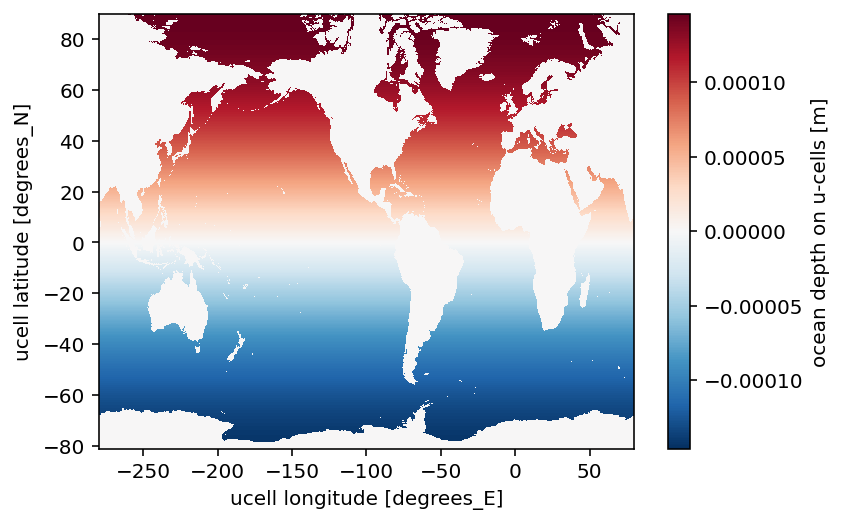

In [6]:
%%time
# calculating f
lat = tau_x_EN_anom.yu_ocean.values
rho_0 = 1035 # kg m**-3
coriolis = 2 * 7.292e-5 * np.sin(lat * np.pi/180)
aa, bb = np.meshgrid(tau_x_EN_anom.xu_ocean.values,coriolis) # create meshgrid

field = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979/ocean/ocean_grid.nc').hu
field = field.fillna(0) # replace all nan with zeroes
landsea_mask = field.where(field>=0,1).where(field<=0,1) # replace all non-zero data with ones
coriolis = bb*landsea_mask
coriolis.plot() # ok, this is the Coriolis parameter for ever grid cell
# Wall time: 2.74 s

Ekman transport:

$u_E = 1/(\rho \times f) \cdot \tau_y$

$v_E = -1/(\rho \times f) \cdot \tau_x$

In [7]:
dxu = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979/ocean/ocean_grid.nc').dxu
dxu

<xarray.DataArray 'dxu' (yu_ocean: 2700, xu_ocean: 3600)>
dask.array<open_dataset-e2ff7fd54416960a24635239802efe7ddxu, shape=(2700, 3600), dtype=float32, chunksize=(2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ... 89.92 89.96 90.0
    geolon_c  (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_c  (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Attributes:
    long_name:     ocean dxu on u-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point

CPU times: user 4.7 s, sys: 704 ms, total: 5.4 s
Wall time: 5.4 s


Text(0.5, 1.0, '$v_{Ekman}$ La Niña')

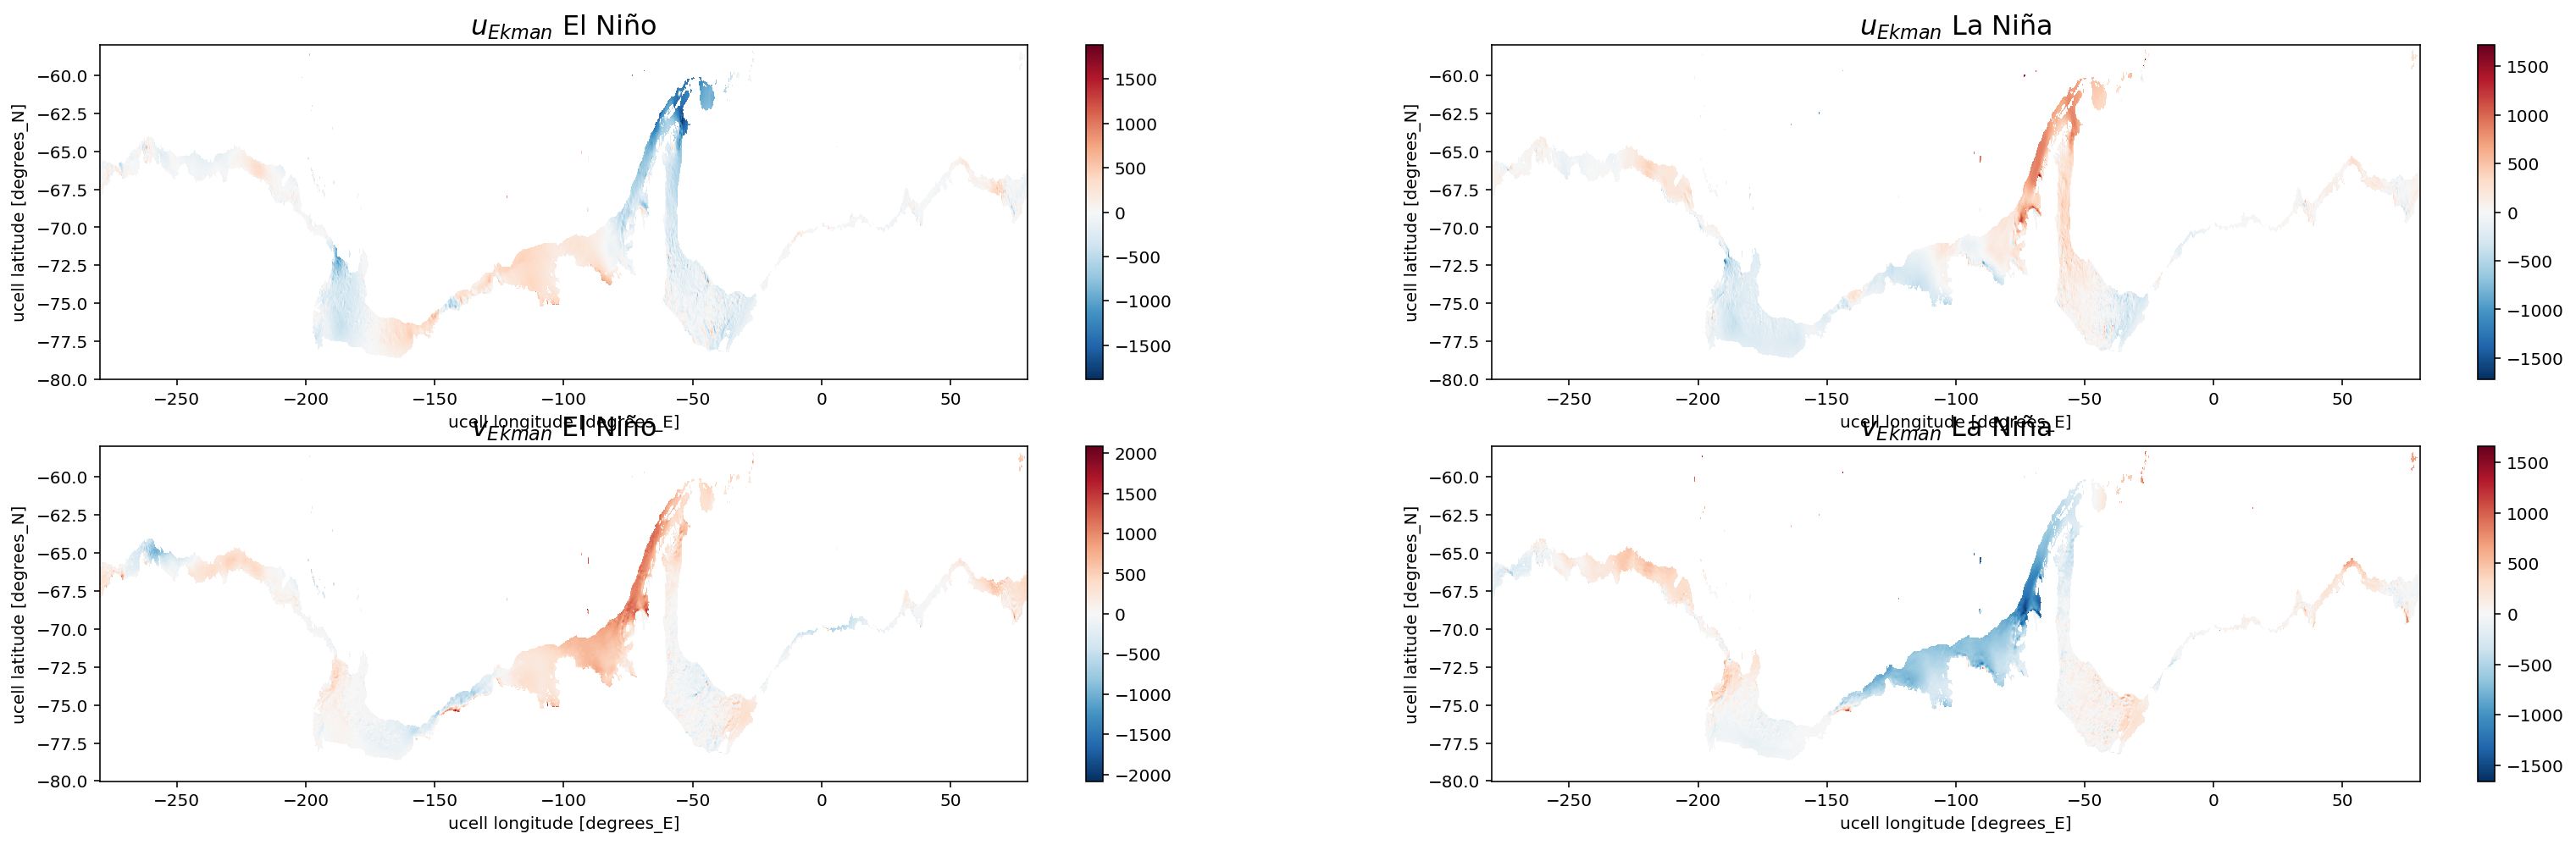

In [8]:
%%time
# select_lat = [ 28, 212]   # 76°S  - 58°S    # these values would be for the 025deg model
sel_lat   = [  26,  529]   # [  26,  529]  = 80.01°S - 58.04°S                      #
u_EN = ((tau_y_EN_anom*(1/(rho_0*coriolis)))*dxu).isel(yu_ocean=slice(sel_lat[0],sel_lat[1])) 
v_EN = ((-tau_x_EN_anom*(1/(rho_0*coriolis)))*dxu).isel(yu_ocean=slice(sel_lat[0],sel_lat[1])) # there is a minus sign for the meridional component, see the equation
u_LN = ((tau_y_LN_anom*(1/(rho_0*coriolis)))*dxu).isel(yu_ocean=slice(sel_lat[0],sel_lat[1]))
v_LN = ((-tau_x_LN_anom*(1/(rho_0*coriolis)))*dxu).isel(yu_ocean=slice(sel_lat[0],sel_lat[1]))

plt.figure(figsize=(27,8))
plt.subplot(2,2,1); u_EN.plot(); plt.title('$u_{Ekman}$ El Niño', fontsize=16); plt.subplot(2,2,2); u_LN.plot(); plt.title('$u_{Ekman}$ La Niña', fontsize=16)
plt.subplot(2,2,3); v_EN.plot(); plt.title('$v_{Ekman}$ El Niño', fontsize=16); plt.subplot(2,2,4); v_LN.plot(); plt.title('$v_{Ekman}$ La Niña', fontsize=16)
# # Wall time: 10.8 s 

CPU times: user 1.59 s, sys: 427 ms, total: 2.02 s
Wall time: 2.02 s


(-150.0, -60.0)

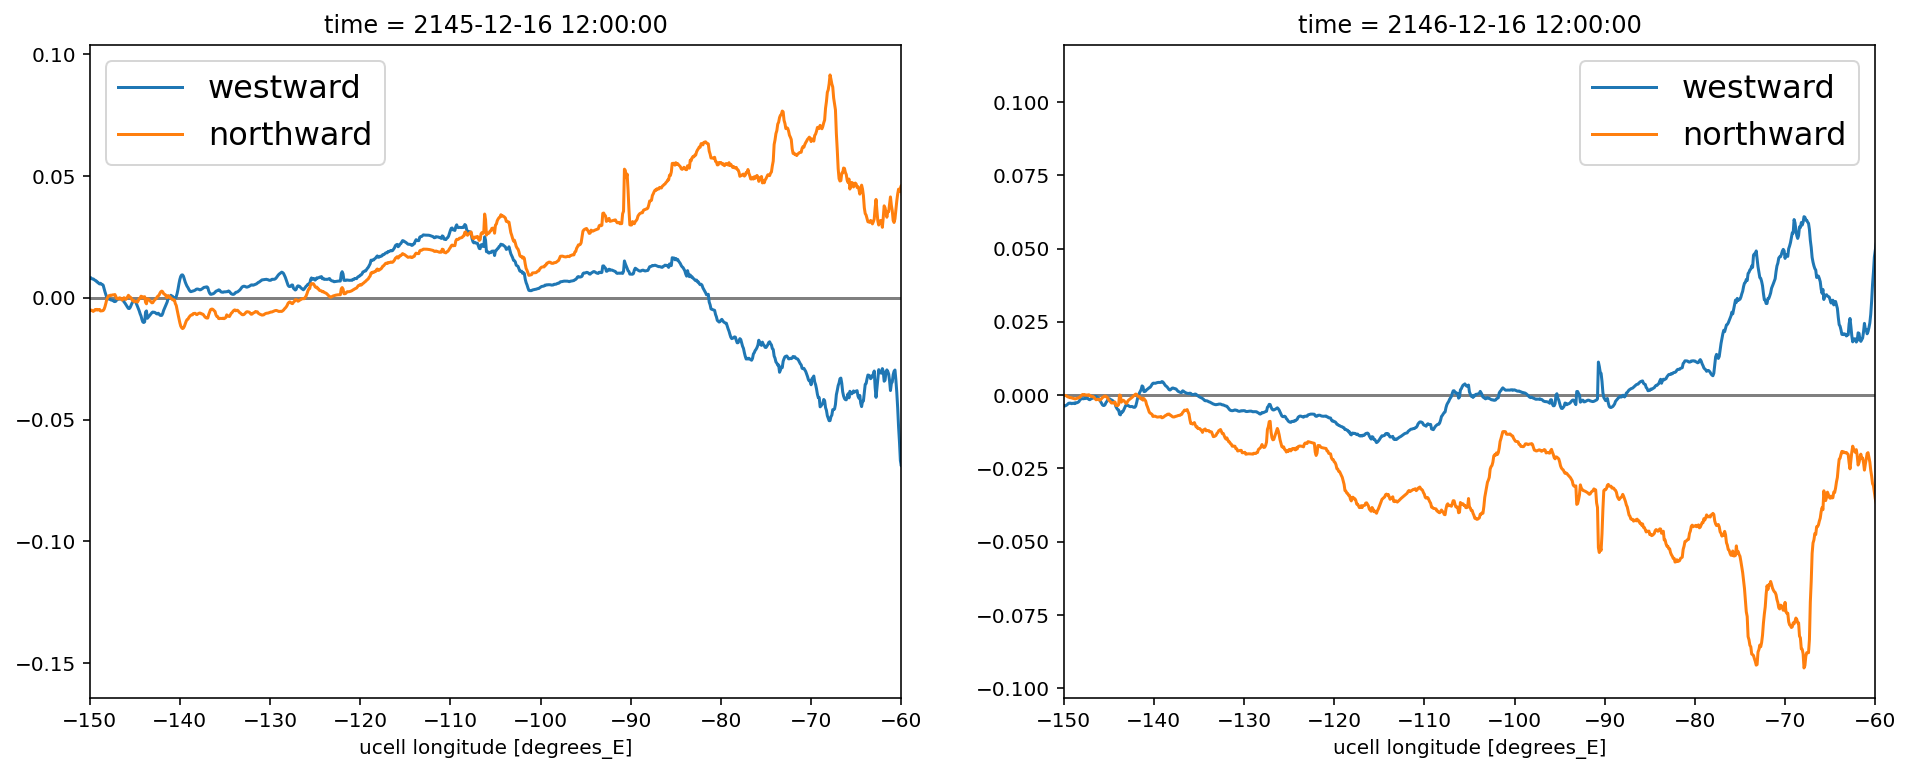

In [9]:
%%time
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.axhline(0, c='grey')
(u_EN.sum(['yu_ocean'])/1e6).plot(label='westward')
(v_EN.sum(['yu_ocean'])/1e6).plot(label='northward'); plt.legend(fontsize=16)
plt.xlim([-150,-60])

plt.subplot(1,2,2)
plt.axhline(0, c='grey')
(u_LN.sum(['yu_ocean'])/1e6).plot(label='westward')
(v_LN.sum(['yu_ocean'])/1e6).plot(label='northward'); plt.legend(fontsize=16)
plt.xlim([-150,-60])

### Adding the depth/latitude plots now below the spatial patterns

In [18]:
%%time
base   = ['/g/data/ik11/outputs/access-om2-01/', '/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/']
exp    = ['01deg_jra55v13_ryf9091','01deg_jra55_ryf_ENFull', '01deg_jra55_ryf_LNFull']
file   = ['ocean.nc', 'ocean_month.nc', 'ocean_month.nc']
region = ['Amundsen Sea', 'Bellingshausen Sea', 'West Antarctica']
# ---------------------------------------------------------------------------------- #
depth     = [   0,   47]  # [  0,    47] = 0.5 m - 1017 m                            #
sel_lat   = [   0,  800]  # [120,   263] = 76.03°S - 70.04°S                         #
sel_lonAS = [1529, 1790]  # [1529, 1790] = 127.1°W - 101.1°W                         #
sel_lonBS = [1790, 2000]  # [1790, 2000] = 101.1°W - 80.05°W                         #
lon_lonWA = [1299, 2200]  # 150°W - 60°W                                             #
# ---------------------------------------------------------------------------------- #
for e in [1,2]: # loop through the two simulations ENFull and LNFull
    if e == 1: last_output = 983; nr_outputs = 8; time_step = 11 # for ENFull, I only have output976-output980
    if e == 2: last_output = 983; nr_outputs = 8; time_step = 23
        
    a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
    s = list(range(0,nr_outputs))
    c = []; d = [] # empty list which I fill up; c for control, d for perturbation simulation
    for i in s: # loop through the number of files I would like
        # fill in empty list with integers trailing two zeros (000, 001, 002, ...)
        c.append(i); c[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[0] # string with all file locations
        d.append(i); d[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[e] # string with all file locations
    temp_clim  = xr.open_mfdataset(c,combine='by_coords',chunks={'time': 1},decode_times = True).temp[time_step,depth[0]:depth[1], sel_lat[0]:sel_lat[1], :] # open data sets
    temp  = xr.open_mfdataset(d,combine='by_coords',chunks={'time': 1},decode_times = True).temp[time_step, depth[0]:depth[1], sel_lat[0]:sel_lat[1], :]
    
    if e == 1: anom_EN = temp - temp_clim
    if e == 2: anom_LN = temp - temp_clim

for e in [1,2]: # loop through the two simulations, ENFull and LNFull
    print(exp[e])
    # del clim; del anom
    for r in [2]:#range(3): # loop through the three regions Amundsen Sea, Bellingshausen Sea and West Antarctica
        print(region[r])
        # if e == 1 and r == 0: anom = anom_EN[:,:,sel_lonAS[0]:sel_lonAS[1]].load(); clim = temp_clim[:,:,sel_lonAS[0]:sel_lonAS[1]].load()
        # if e == 1 and r == 1: anom = anom_EN[:,:,sel_lonBS[0]:sel_lonBS[1]].load(); clim = temp_clim[:,:,sel_lonBS[0]:sel_lonBS[1]].load()
        if e == 1 and r == 2: anom = anom_EN[:,:,lon_lonWA[0]:lon_lonWA[1]].load(); clim = temp_clim[:,:,lon_lonWA[0]:lon_lonWA[1]].load()
        # if e == 2 and r == 0: anom = anom_LN[:,:,sel_lonAS[0]:sel_lonAS[1]].load(); clim = temp_clim[:,:,sel_lonAS[0]:sel_lonAS[1]].load()
        # if e == 2 and r == 1: anom = anom_LN[:,:,sel_lonBS[0]:sel_lonBS[1]].load(); clim = temp_clim[:,:,sel_lonBS[0]:sel_lonBS[1]].load()
        if e == 2 and r == 2: anom = anom_LN[:,:,lon_lonWA[0]:lon_lonWA[1]].load(); clim = temp_clim[:,:,lon_lonWA[0]:lon_lonWA[1]].load() 

        # replace the different sections that have data south of the 1000 m isobath with nan (i.e., the regions that are deeper than 1000 m)
        for s in range(2): # loop through both the climatological and anomalous arrays
            if s == 0: array = clim
            if s == 1: array = anom 
            array[-1,0:160,90:]    = array[-1,    0:160,90:].where(array[-1,   0:160, 90:] < 5)
            array[-1,150:200,300:] = array[-1, 150:200,300:].where(array[-1, 150:200,300:] < 5)
            array[-1,180:290,728:] = array[-1, 180:290,728:].where(array[-1, 180:290,728:] < 5)
            array[-1,250:300,740:] = array[-1, 250:300,740:].where(array[-1, 250:300,740:] < 5)
            array[-1,300:390,830:] = array[-1, 300:390,830:].where(array[-1, 300:390,830:] < 5)
            array[-1,400:439,880:] = array[-1, 400:439,880:].where(array[-1, 400:439,880:] < 5)
            array[-1,:249,550:]    = array[-1,    :249,550:].where(array[-1,    :249,550:] < 5)
            # array[-1,:220,:]      = array[-1,   0:220,   :].where(array[-1,      0:220,:] < 5)
            # array[-1,:258,140:250]= array[-1,0:258,140:250].where(array[-1,0:258,140:250] < 5)
            if s == 0: clim = array
            if s == 1: anom = array
        # from here, shift the data to get a depth/distance from shelf plot
        clim_shift = clim.where(clim>=0).where(clim<=0) # copy data structure for meridionally-shifted anomalies
        anom_shift = clim.where(clim>=0).where(clim<=0) # ... and at the same time, replace all the data with NaNs

        align = 262 # 144 = shelf-break at 75.02616465°S, 262 = shelf-break at 70.04192083°S
        for lon in range(len(clim.xt_ocean)): # loop through all longitudes
            shelf_break_index = pd.Series(clim[-1,:,lon]).first_valid_index() # get the first non-NAN value in the deepest st_ocean layer, ...
                                                                              # i.e., the first temperature value north of the shelf break 
            if shelf_break_index == None:
                anom_shift[:,:,lon] = anom[:,:,lon] # no shift in any direction
                clim_shift[:,:,lon] = clim[:,:,lon]
            elif shelf_break_index == align:
                anom_shift[:,:,lon] = anom[:,:,lon] # no shift in any direction
                clim_shift[:,:,lon] = clim[:,:,lon]
            elif shelf_break_index > align:
                anom_shift[:,:,lon] = anom[:,:,lon].shift(yt_ocean=-(shelf_break_index-align)) # shift southward
                clim_shift[:,:,lon] = clim[:,:,lon].shift(yt_ocean=-(shelf_break_index-align))
            elif shelf_break_index < align:
                anom_shift[:,:,lon] = anom[:,:,lon].shift(yt_ocean=(align-shelf_break_index)) # shift northward
                clim_shift[:,:,lon] = clim[:,:,lon].shift(yt_ocean=(align-shelf_break_index))                              

01deg_jra55_ryf_ENFull
West Antarctica
01deg_jra55_ryf_LNFull
West Antarctica
CPU times: user 16.2 s, sys: 1.49 s, total: 17.7 s
Wall time: 17 s


CPU times: user 169 ms, sys: 3.7 ms, total: 173 ms
Wall time: 170 ms


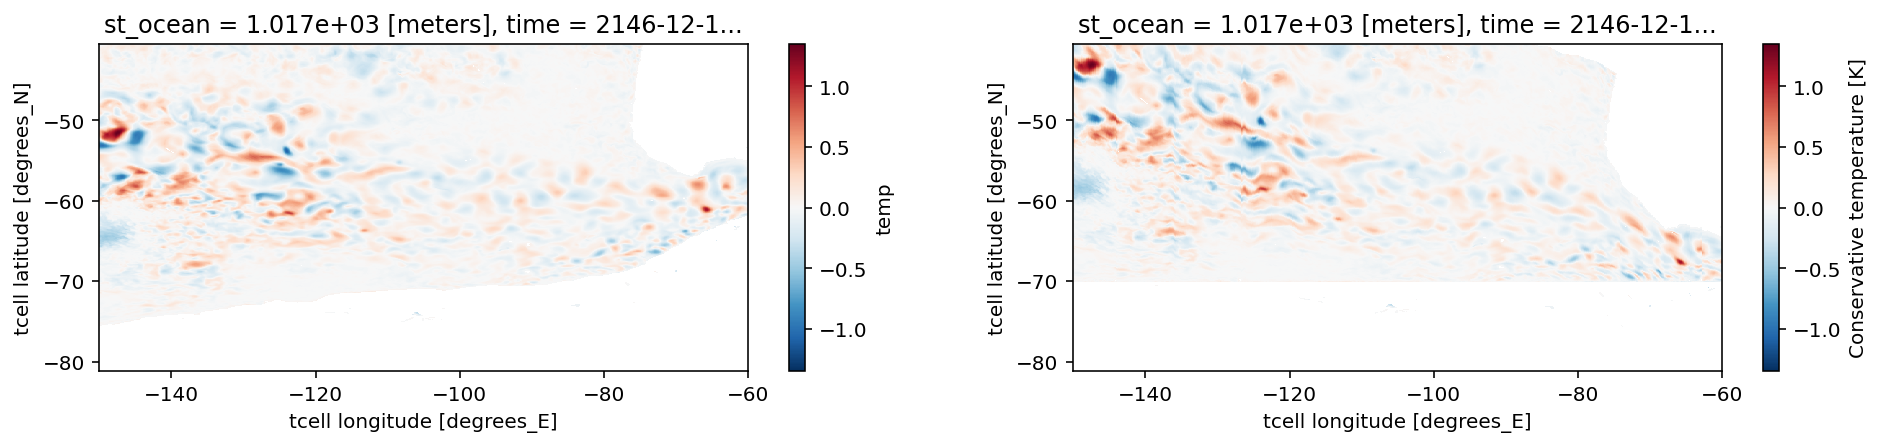

In [19]:
%%time
plt.figure(figsize=(16,3))
plt.subplot(1,2,1); anom[-1,:,:].plot()
plt.subplot(1,2,2); anom_shift[-1,:,:].plot()
# Wall time: 170 ms

In [68]:
lat_to_km = 2*np.pi*Re/360.0/1e3;

w = 10  # width of rectangle
x = -100 # x-center [lon]
y = -72 # y-center [lat]

O = 20 # offshore length [need in km] 
N = 5 # onshore length [need in km]
ang = 20 * (np.pi/180) # angle of coastline
delx = .5 # [need in km]
dely = .5 # [need in km]

x_r = np.linspace(-w,w,int(2*w/delx)) # start, stop, step of 
y_r = np.linspace(-N,O,int((N+O)/dely))
XY_r = np.meshgrid(x_r, y_r) 

lat_rot = np.zeros((len(x_r), len(y_r)))
lon_rot = np.zeros((len(x_r), len(y_r)))

In [104]:
import math 
for i in range(len(x_r)):
    for j in range(len(y_r)):
        phi = math.atan2(y_r[j],x_r[i]);      # angle from center point
        leng = np.sqrt(x_r[i]**2+y_r[j]**2);  # distance from center point

        lat_rot[i,j] = y + np.sin(phi+ang)*leng; # lat of point
        lon_rot[i,j] = x + np.cos(phi+ang)*leng # / np.cos(np.pi/180*(lat_rot[i,j]+y)/2);  # lon of point

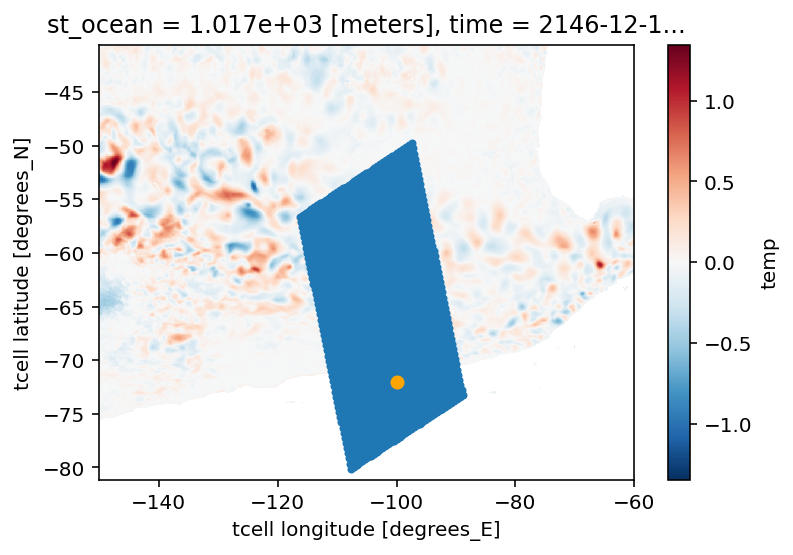

In [105]:
anom[-1,:,:].plot()
plt.plot(x,y, marker = 'o', c = 'orange')
plt.scatter(lon_rot.reshape(-1), lat_rot.reshape(-1), marker = '.')

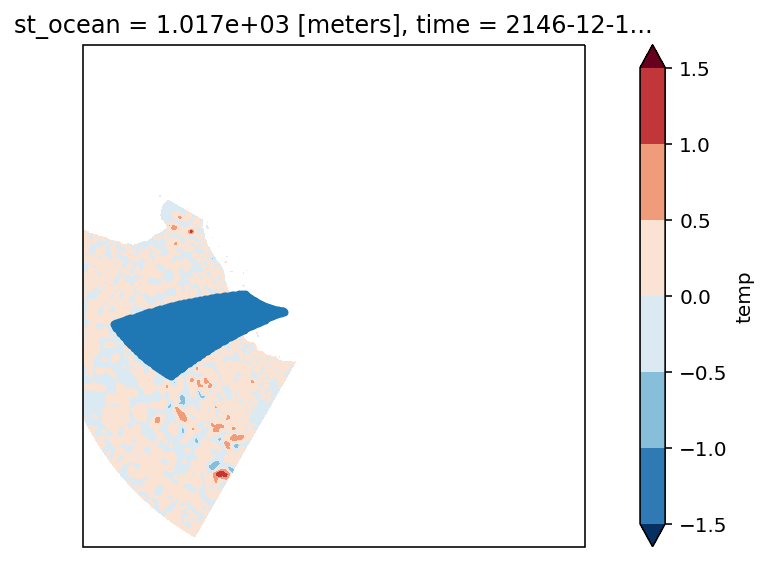

In [106]:
fig = plt.figure(figsize=(8,4),tight_layout=True,facecolor='w',edgecolor='k'); gs = gridspec.GridSpec(1,1) 

ax1 = plt.subplot(projection=ccrs.SouthPolarStereo(central_longitude=0)).set_extent([-180, 180, -90, -45], crs=ccrs.PlateCarree())
p1  = anom[-1,:,:].plot.contourf(ax=ax1, cmp='RdBu_r',add_colorbar=True,extend='both',transform=ccrs.PlateCarree())

p1  = plt.scatter(lon_rot.reshape(-1), lat_rot.reshape(-1), marker = '.', transform=ccrs.PlateCarree())


In [107]:
import scipy
# create interpolation function (old x-axis, old y-axis, old data)
function = scipy.interpolate.interp2d(anom.xt_ocean, anom.yt_ocean, anom[-1,:,:].fillna(0))









                  #                   new x-axis,          new y-axis
interpolated_data = np.zeros_like(lon_rot) # create same matrix as lon_rot
for i in range(len(x_r)):
    for j in range(len(y_r)):
        interpolated_data[i,j] = function(lon_rot[i,j], lat_rot[i,j])

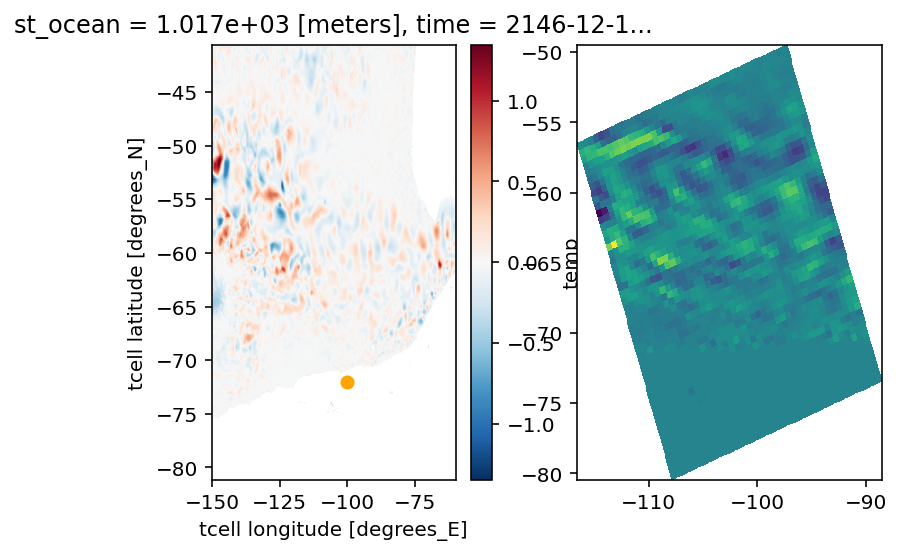

In [111]:
plt.subplot(1,2,1)
anom[-1,:,:].plot()
plt.plot(x,y, marker = 'o', c = 'orange')
# plt.scatter(lon_rot.reshape(-1), lat_rot.reshape(-1), marker = '.')
plt.subplot(1,2,2); plt.pcolormesh(lon_rot, lat_rot, interpolated_data)

- make xarray object
- functionalise it (all params as input)
- do it in km instead of lon/lat
- do for all depth levels
----

- 

In [103]:
interpolated_data

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.06175672e-01,  3.30634583e-01,  2.72437078e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         7.33340168e-02, -8.55055464e-02, -2.19385508e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.03467185e-02, -2.56235345e-04,  1.78244272e-02],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -7.83277003e-03, -9.35503548e-03, -1.35061780e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.92638835e-02,  1.52499542e-02,  7.14985169e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         8.03269063e-03, -1.89809817e-02,  1.32179314e-02]])

In [93]:
len(lat_rot.reshape(-1))

2000

In [91]:
interpolated_data.shape

(2000, 2000)

1 to 11
11 to 21
21 to 31
31 to 41
41 to 51
51 to 61
61 to 71
71 to 81
81 to 91
91 to 101
101 to 111
111 to 121
121 to 131
131 to 141
141 to 151
151 to 161
161 to 171
171 to 181
181 to 191
191 to 201
201 to 211
211 to 221
221 to 231
231 to 241
241 to 251
251 to 261
261 to 271
271 to 281
281 to 291
291 to 301
301 to 311
311 to 321
321 to 331
331 to 341
341 to 351
351 to 361
361 to 371
371 to 381
381 to 391
391 to 401
401 to 411
411 to 421
421 to 431
431 to 441
441 to 451
451 to 461
461 to 471
471 to 481
481 to 491
491 to 501
501 to 511
511 to 521
521 to 531
531 to 541
541 to 551
551 to 561
561 to 571
571 to 581
581 to 591
591 to 601
601 to 611
611 to 621
621 to 631
631 to 641
641 to 651
651 to 661
661 to 671
671 to 681
681 to 691
691 to 701
701 to 711
711 to 721
721 to 731
731 to 741
741 to 751
751 to 761
761 to 771
771 to 781
781 to 791
791 to 801
801 to 811
811 to 821
821 to 831
831 to 841
841 to 851
851 to 861
861 to 871
871 to 881
881 to 891
891 to 901


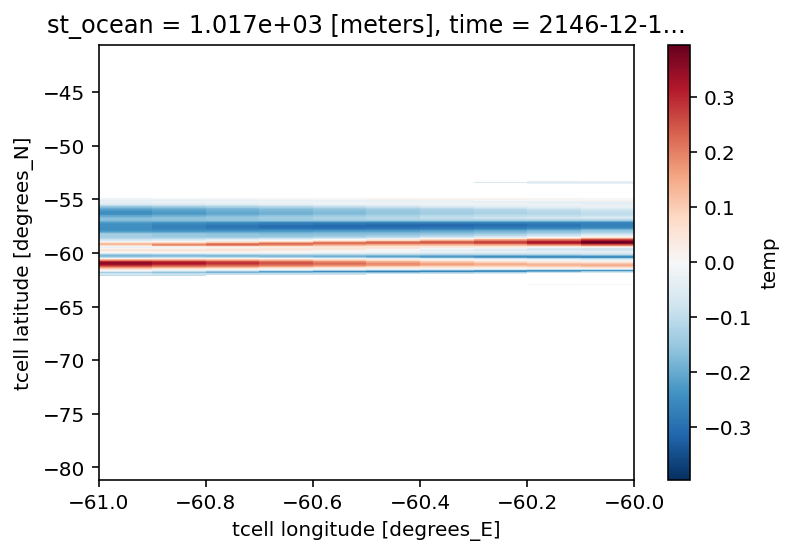

In [22]:
a = anom[-1,:,:]
a.xt_ocean

p1 = np.linspace(1, len(a.xt_ocean), len(a.xt_ocean))

for f,g in zip(p1[0::10],p1[10::10]): # loop through blocks of ten grid cells
    print(str(int(f)) + ' to ' + str(int(g)))
    a[:,int(f):int(g)] # select subset and remove integers from loop variables -> 1, 10 instead of 1.0, 10.0
    # print('---')        

a[:,int(f):int(g)].plot()  


In [10]:
        anom_shift = anom_shift.mean('xt_ocean')
        clim_shift = clim_shift.mean('xt_ocean') # take mean over longitudes      
        # assign data for plotting later
        if e == 1 and r == 0: shelf_AS_EN = anom_shift; shelf_AS_clim = clim_shift - 273.15 # convert climatological isotherms to °C
        if e == 1 and r == 1: shelf_BS_EN = anom_shift; shelf_BS_clim = clim_shift - 273.15
        if e == 1 and r == 2: shelf_WA_EN = anom_shift; shelf_WA_clim = clim_shift - 273.15
        if e == 2 and r == 0: shelf_AS_LN = anom_shift
        if e == 2 and r == 1: shelf_BS_LN = anom_shift
        if e == 2 and r == 2: shelf_WA_LN = anom_shift
    print('-------------------------------')

01deg_jra55_ryf_ENFull
West Antarctica
-------------------------------
01deg_jra55_ryf_LNFull
West Antarctica
-------------------------------
CPU times: user 16.7 s, sys: 1.63 s, total: 18.3 s
Wall time: 17.6 s


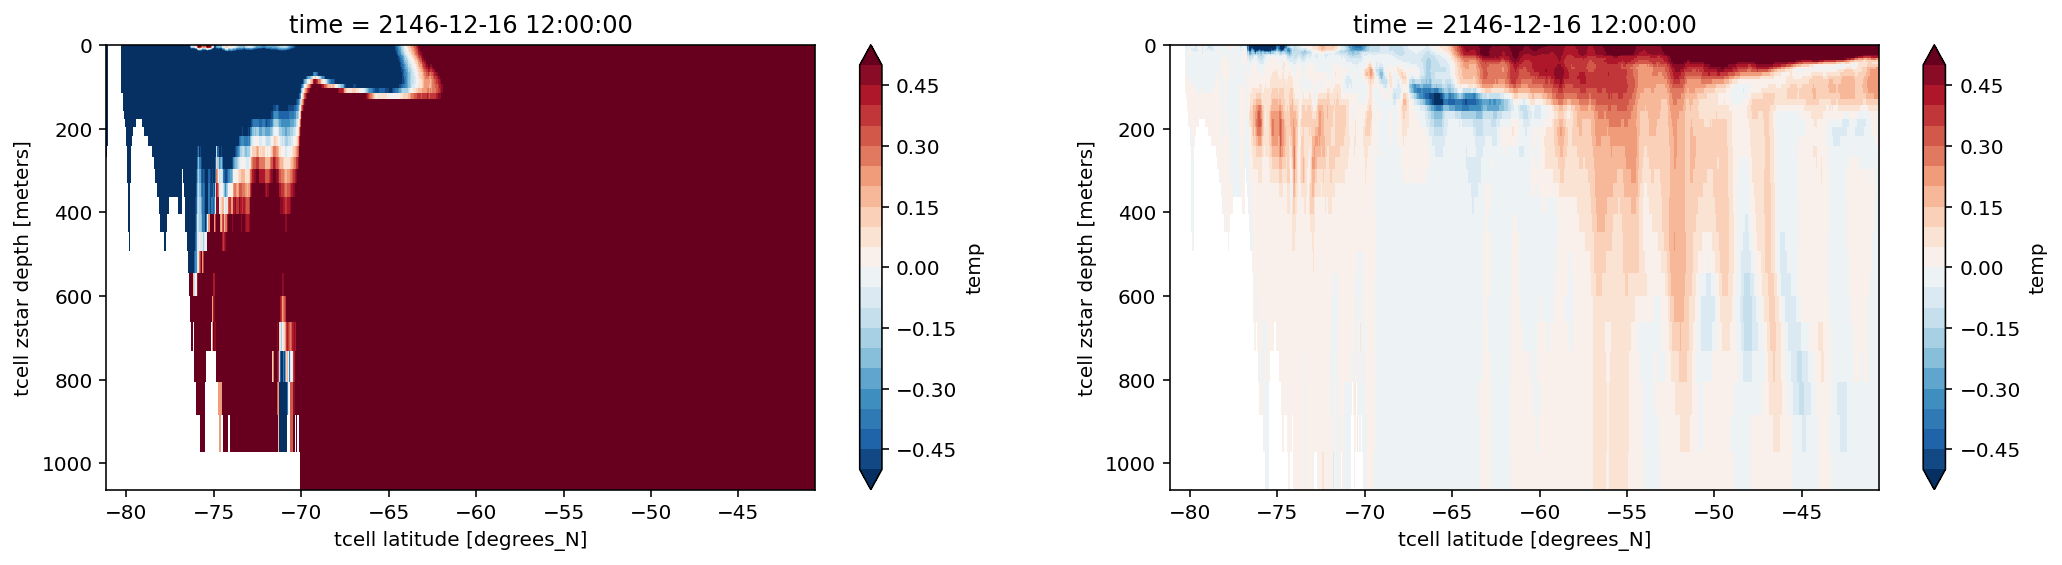

In [11]:
ticks = np.linspace(-.5,.5,21)
plt.figure(figsize=(27,9))
# plt.subplot(2,3,1); shelf_AS_.plot(yincrease=False); 
# plt.subplot(2,3,2); shelf_AS_EN.mean('xt_ocean').plot(yincrease=False, levels=ticks); plt.subplot(2,3,3); shelf_AS_LN.mean('xt_ocean').plot(yincrease=False,levels=ticks)
plt.subplot(2,3,5); shelf_WA_clim.plot(yincrease=False, levels=ticks); plt.subplot(2,3,6); shelf_WA_EN.plot(yincrease=False,levels=ticks)
# Wall time: 13.4 s

Text(0.5, 1.0, 'Section at 75°W')

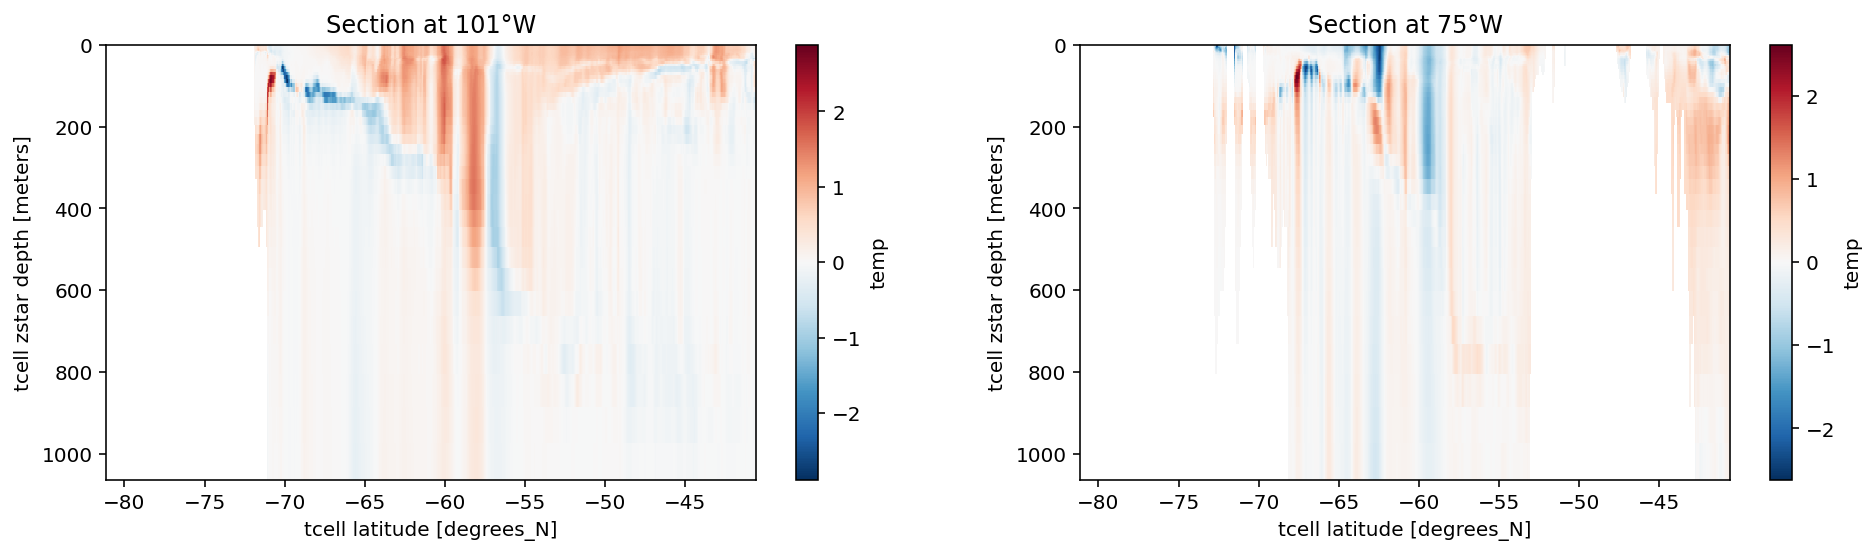

In [12]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1); anom_EN[:,:,1790].plot(yincrease=False); plt.title('Section at 101°W')
plt.subplot(1,2,2); anom_EN[:,:,2049].plot(yincrease=False); plt.title('Section at 75°W')

### Load in the climatological isotherm positions

In [13]:
# %%time
# base = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output'

# # ----------------------------------------------------------------------------- #
# nr_outputs  =  20  # define number of output files to consider
# last_output = 979  # the last output to consider loading in
# # ----------------------------------------------------------------------------- #
# a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
# s = list(range(0,nr_outputs))
# c = [] # empty list which I fill up
# for i in s: # loop through the number of files I would like
#     c.append(i)
#     # fill in empty list with integers trailing two zeros (000, 001, 002, ...)
#     c[i] = base+str(a[i]).zfill(3) + '/ocean/ocean.nc' 
    
# for f in [1,2]:        # loop through the two perturbation runs
#     print(run[f])
#     for r in [0,1]: # loop through the two regions Amundsen and Bellingshausen Sea
#         if r == 0:     # region 1: Amundsen Sea
#             print('region 1: Amundsen Sea')
#             depth      = [   0,   47]   # [  0,    47] = 0.5 m - 1017 m
#             select_lat = [   0,  263]   # [120,   263] = 76.03°S - 70.04°S
#             select_lon = [1529, 1790] # [1529, 1790] = 127.05°W - 101.05°W
#         if r == 1:     # Bellingshausen Sea
#             print('region 2: Bellingshausen Sea')
#             depth      = [   0,   47]   # [  0,    47] = 0.5 m - 1017 m                                   
#             select_lat = [   0,  263]  # [120,   263] = 76.03°S - 70.04°S
#             select_lon = [1790, 2000] # [1790, 2000] = 101.05°W - 80.05°W
            
#         # load in data set ------------------------------------------------------------ #
#         temp = xr.open_mfdataset(c,combine='by_coords',chunks={'time': 1},decode_times = True).temp
#         temp = temp.isel(yt_ocean=slice(select_lat[0],select_lat[1])).isel(xt_ocean=slice(select_lon[0],select_lon[1])).isel(st_ocean=slice(depth[0],depth[1]))
#         temp = temp.mean(['time']).load() # take climatological mean

#         b = temp
        
#         align = 48 # center of Amundsen Sea plot = 74.01°S
#         for lon in range(len(temp.xt_ocean)): # loop through all longitudes
#             shelf_break_index = pd.Series(temp[-1,:,lon]).first_valid_index() # get the first non-NAN value in the deepest st_ocean layer, ...
#                                                                               # i.e., the first temperature value north of the shelf break   
#             if shelf_break_index == None:
#                 b[:,:,lon] = 'nan'
#                 continue
#             if shelf_break_index < align: # shift to the right (i.e., north)
#                 shift = (shelf_break_index-align)
#             if shelf_break_index > align: # shift to the left (i.e., south)
#                 shift = -(shelf_break_index-align)                
            
#             # print(shelf_break_index, shift)    
#             b[:,:,lon] = temp[:,:,lon].shift(yt_ocean=shift) # shift data so that the shelf aligns at grid cell 104, i.e., at 70°S 
#         b = b.isel(yt_ocean=slice(0,48)) # select only up to 72°S

#         if f == 1 and r == 0: shelf_AS_EN_clim = b - 273.15 # convert to °C
#         if f == 2 and r == 0: shelf_AS_LN_clim = b - 273.15
#         if f == 1 and r == 1: shelf_BS_EN_clim = b - 273.15
#         if f == 2 and r == 1: shelf_BS_LN_clim = b - 273.15
# # Wall time: 1min 4s

### Calculate Eulerian heat budget terms

In [14]:
# %%time
# base   = ['/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/']
# exp    = ['01deg_jra55_ryf_Control','01deg_jra55_ryf_ENFull', '01deg_jra55_ryf_LNFull']
# file   = ['ocean.nc', 'ocean_month.nc', 'ocean_month.nc', 'ocean_heat.nc']


# # base   = ['/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/']
# # exp    = ['025deg_jra55_ryf_ENControl','025deg_jra55_ryf_ENFull', '025deg_jra55_ryf_LNFull']
# # region = ['Amundsen Sea', 'Bellingshausen Sea', 'West Antarctica']


# # --------------------------------------------------------------------------------------------------------------------------- #
# depth     = [  23,   47]  # [  0,    47] = 0.5 m - 1017 m                                                                     #
# sel_lat   = [   0,  400]  # [120,   263] = 76.03°S - 70.04°S                                                                  #
# lon_lonWA = [1299, 2200]  # 150°W - 60°W                                                                                      #
# # depth     = [  23,   47]  # specifics for the ACCESS-OM2-025 model                                                          #
# # sel_lat   = [   0,  107]  # 81.07°S - 70.09°S                                                                               #
# # lon_lonWA = [519, 880]  # 150.125°W - 60.125°W                                                                              #
# # --------------------------------------------------------------------------------------------------------------------------- #
# rho_0     = 1035          # reference density [1035 kg * m^-3]                                                                #
# C_p       = 3992.1        # reference specific heat capacity [3992.1 J * kg^-1 * K^-1]                                        #
# area_t      = xr.open_mfdataset(base[0]+exp[0]+'/output976/ocean/ocean_grid.nc').area_t[                                      #
#               sel_lat[0]:sel_lat[1], lon_lonWA[0]:lon_lonWA[1]]                                                               #
# # area_t      = xr.open_mfdataset(base[0]+exp[0]+'/output325/ocean/ocean_grid.nc').area_t[
# #               sel_lat[0]:sel_lat[1], lon_lonWA[0]:lon_lonWA[1]] 

# var  = ['temp_submeso',
#         'temp_tendency',                                                                              # ocean heat tendency   #
#         'temp_advection',                                                                             # advection terms       #
#         'temp_vdiffuse_diff_cbt', 'temp_nonlocal_KPP',                                                # surface forcing terms #
#         'sw_heat', 'temp_vdiffuse_sbc', 'sfc_hflux_pme',                                              # vertical mixing terms #
#         'frazil_3d', 'temp_eta_smooth',                                                               # surface heat fluxes   #
#         'temp_rivermix']                                                                              # surface volume flux   #
# # variables in temperature space                                                                                              #
# var2 = ['tx_trans_nrho', 'ty_trans_nrho',                                                             # advection terms       #
#         'mass_pmepr_on_nrho',                                                                         # surface volume flux   #
#         'temp_vdiffuse_diff_cbt_on_nrho', 'temp_nonlocal_KPP_on_nrho',                                # surface forcing terms #
#         'temp_vdiffuse_sbc_on_nrho', 'sw_heat_on_nrho', 'frazil_on_nrho', 'temp_eta_smooth_on_nrho']  # vertical mixing terms #
# # --------------------------------------------------------------------------------------------------------------------------- #

# for e in [1,2]: # loop through the two simulations ENFull and LNFull
#     print('Loading in '+ exp[e] + ' for the Eulerian heat budget:')
#     if e == 1: last_output = 983; nr_outputs =  8 # for ENFull, I only have output976-output980
#     if e == 2: last_output = 987; nr_outputs = 12
    
#     a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
#     s = list(range(0,nr_outputs))
#     c = []; d = []; f = []; g = [] # empty list which I fill up; c for control, d for perturbation simulation
#     for i in s: # loop through the number of files I would like
#         # fill in empty list with integers trailing two zeros (000, 001, 002, ...)       
#         f.append(i); f[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[3] # string with all file locations
#         g.append(i); g[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[3]         
    
#     # open data sets 
#     # --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- #
#     # temp_clim  = xr.open_mfdataset(c,combine='by_coords',chunks={'time': 1},decode_times = True).temp[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], lon_lonWA[0]:lon_lonWA[1]] 
#     # temp       = xr.open_mfdataset(d,combine='by_coords',chunks={'time': 1},decode_times = True).temp[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], lon_lonWA[0]:lon_lonWA[1]]
    
#     for v in range(len(var)): # loop through the eight diagnostics I need to balance the heat budget
#         print(var[v])
#         if v in [0, 1, 2, 3, 4, 5, 6, 8, 10]:
#             variable_clim = xr.open_mfdataset(f,combine='by_coords',chunks={'time': 1},decode_times = True)[
#                 var[v]][:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], lon_lonWA[0]:lon_lonWA[1]]
#             variable      = xr.open_mfdataset(g,combine='by_coords',chunks={'time': 1},decode_times = True)[
#                 var[v]][:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], lon_lonWA[0]:lon_lonWA[1]]
                    
#         if v in [7, 9]: # these two fields (sfc_hflux_pme & temp_eta_smooth) are only 3D (time, latitude, longitude)
#             variable_clim = xr.open_mfdataset(f,combine='by_coords',chunks={'time': 1},decode_times = True)[var[v]][:, sel_lat[0]:sel_lat[1], lon_lonWA[0]:lon_lonWA[1]]
#             variable      = xr.open_mfdataset(g,combine='by_coords',chunks={'time': 1},decode_times = True)[var[v]][:, sel_lat[0]:sel_lat[1], lon_lonWA[0]:lon_lonWA[1]]  
        
#         # -------------------------------------------------------------------------------------- #
#         variable = ((variable - variable_clim) * above1000_tcells).sum(['yt_ocean', 'xt_ocean']) # calculate anomalies by removing the control and multiply with shelf mask
#         # -------------------------------------------------------------------------------------- #
        
#         if v ==  0: temp_submeso           = variable.sum(['st_ocean']).load() # calculate time series for each flux
#         if v ==  1: temp_tendency          = variable.sum(['st_ocean']).load()
#         if v ==  2: temp_advection         = variable.sum(['st_ocean']).load()
#         if v ==  3: temp_vdiffuse_diff_cbt = variable.sum(['st_ocean']).load()
#         if v ==  4: temp_nonlocal_KPP      = variable.sum(['st_ocean']).load()
#         if v ==  5: sw_heat                = variable.sum(['st_ocean']).load()
#         if v ==  6: temp_vdiffuse_sbc      = variable.sum(['st_ocean']).load()
#         if v ==  7: sfc_hflux_pme          = variable.load()
#         if v ==  8: frazil_3d              = variable.sum(['st_ocean']).load()
#         if v ==  9: temp_eta_smooth        = variable.load()
#         if v == 10: temp_rivermix          = variable.sum(['st_ocean']).load()
#     if e == 1:
#         temp_submeso_EN = temp_submeso; temp_tendency_EN = temp_tendency; temp_advection_EN = temp_advection; temp_vdiffuse_diff_cbt_EN = temp_vdiffuse_diff_cbt
#         temp_nonlocal_KPP_EN = temp_nonlocal_KPP; sw_heat_EN = sw_heat; temp_vdiffuse_sbc_EN = temp_vdiffuse_sbc; sfc_hflux_pme_EN = sfc_hflux_pme;
#         frazil_3d_EN = frazil_3d; temp_eta_smooth_EN = temp_eta_smooth; temp_rivermix_EN = temp_rivermix
#     if e == 2:
#         temp_submeso_LN = temp_submeso; temp_tendency_LN = temp_tendency; temp_advection_LN = temp_advection; temp_vdiffuse_diff_cbt_LN = temp_vdiffuse_diff_cbt
#         temp_nonlocal_KPP_LN = temp_nonlocal_KPP; sw_heat_LN = sw_heat; temp_vdiffuse_sbc_LN = temp_vdiffuse_sbc; sfc_hflux_pme_LN = sfc_hflux_pme;
#         frazil_3d_LN = frazil_3d; temp_eta_smooth_LN = temp_eta_smooth; temp_rivermix_LN = temp_rivermix
#     # --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- - --- #
#     print('---------------------------------')
# # Wall time: 17min 51s

### Define functions for plotting

In [15]:
%%time
from matplotlib import ticker
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
import matplotlib.patheffects as PathEffects
import string # for subplot annotation  

# function to make boundary path
# make a path around boundary to create a sector map, then cut it out
def make_boundary_path(lons, lats):
    boundary_path = np.array([lons[-1, :], lats[-1, :]])
    boundary_path = np.append(boundary_path, np.array([lons[::-1, -1], lats[::-1, -1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([lons[1, ::-1], lats[1, ::-1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([lons[:, 1], lats[:, 1]]), axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))
    return boundary_path
def fancy_plot(ax):
    ax.gridlines(color='grey', linewidth=1, alpha=1, # dots as grid lines
                  xlocs=range(-180, 180, 30), # longitude grid lines
                  ylocs= np.linspace(0, -90, num=10)) # latitude grid lines
    ax.coastlines(); # add coast lines
    # theta = np.linspace(0, 2*np.pi, 100); center, radius = [0.5, 0.5], .5
    # verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    # circle = mpath.Path(verts * radius + center)
    # ax.set_boundary(circle, transform=ax.transAxes)
    # colour in land and coastlines
    ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 2)
    
    # xlab =    [ 3.2,    2.4,    1.1,    .12,     -.4,     .3,    .85] # x-position of labels
    xlab =    [   .93,     .06,   -.01,    .15,     .3,     .36,    .68]#,     .41] # x-position of labels
    ylab =    [    .7,      .7,    .29,    .11,   -.07,       1,      1]#,     .05] # y-position of labels
    txt_lab = ['60°W', '150°W', '60°S', '70°S', '80°S', '120°W', '90°W']#, '150°W'] # label text
    # loop through the 7 label and surround with white space for higher visibility
    if f == 0:
        for l in range(len(xlab)):
            ax.text(xlab[l], ylab[l], txt_lab[l], horizontalalignment='center', transform=ax1.transAxes, 
                    fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])     
def fancy_plot2(ax, titel):
    ax1.set_facecolor([.83, .83, .83]) # grey background for the shelf

    plt.title(titel, fontsize=16)
    # plt.ylabel('Depth (m)', fontsize=16)
    ax1.tick_params(axis='y', labelcolor='k')
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    # plt.xlabel(None) # no x-label
    
    # replace the xticklabels with kilometer values -> I can do that because latitude distance is constant
    # labels = [item.get_text() for item in ax1.get_xticklabels()]
    # labels =       ['440', '330', '220', '110', '0', '0', '55', '110']
    # ax1.set_xticklabels(labels)   
def fancy_plot3(ax):
        ax.axhline(0, linewidth=.5, c='grey') # horizontal line at 0
        
        plt.title(titel, fontsize=16)
        plt.xlim([-150,-60]); plt.ylim([-.1,.1])
        ax.tick_params(axis='y', labelcolor='k')
        plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        ax.set_ylabel('(Sv)', color='k', fontsize=16); ax1.set(xlabel=None) # hide x-axis label
        
        ax.set_xticks([-150, -120, -90, -60]) # custom x ticks
        labels = [item.get_text() for item in ax1.get_xticklabels()] # rewrite the labels to °W/°E
        labels =       ['150°W', '120°W', '90°W', '60°W']
        ax.set_xticklabels(labels)  

def fancy_plot4(ax):
        ax.axhline(0, linewidth=.5, c='grey') # horizontal line at 0
        
        plt.title(titel, fontsize=16)
        # plt.ylim([-5.5, 7.5]); plt.xlim([-150,-60])
        ax.tick_params(axis='y', labelcolor='k')
        plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        ax.set_ylabel('(W m$^{-2}$)', color='k', fontsize=16); ax1.set(xlabel=None) # hide x-axis label
        
        
#         # shading the AS and BS sectors
#         AS = [-127,-101,-76,-70]; BS = [-101,-80,-76,-70]
#         #                         x0,  y0,       x-increase, y-increase
#         r1 = mpatch.Rectangle((AS[0], -5), abs(AS[0]-AS[1]), 1.25, color =rotblau[ 9]); ax1.add_patch(r1)
#         r2 = mpatch.Rectangle((BS[0], -5), abs(BS[0]-BS[1]), 1.25, color =rotblau[11]); ax1.add_patch(r2)
#         ax1.text(AS[0]+abs(AS[0]-AS[1])/2, -4.5, 'AS',ha='center',va='center', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
#         ax1.text(BS[0]+abs(BS[0]-BS[1])/2, -4.5, 'BS',ha='center',va='center', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        
        # old version how I shaded the AS and BS sectors
        AS = [-127,-101,-76,-70]; BS = [-101,-80,-76,-70]
        # ax.axvspan(AS[0], AS[1], color=[.83,.83,.83], alpha=.25) 
        # ax.axvspan(BS[0], BS[1], color=[.83,.83,.83], alpha=.25)    
        # ax.axvline(AS[0], linewidth=2.5, c='k'); ax.axvline(AS[1], linewidth=2.5, c='k'); ax.axvline(BS[1], linewidth=2.5, c='k')
        # adding text labels
        # ax1.text(-121, 6, 'AS',ha='center',va='center', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        # ax1.text( -95, 6, 'BS',ha='center',va='center', fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        
#         ax.text(-.02, 1.1 ,string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
#         # adding text at the right side
#         ax.text(-335,16,'Eastward', fontsize=16, rotation=90, c='grey', va='top'); ax1.text(-335,-11,'Westward', fontsize=16, rotation=90, c='grey', va='bottom')   

CPU times: user 29 ms, sys: 3.33 ms, total: 32.3 ms
Wall time: 37.9 ms


### Quick plot Eulerian heat budget

In [16]:
# %%time

# fig, ax1 = plt.subplots(figsize=(14,4),tight_layout=True,facecolor='w',edgecolor='k')
# gs = gridspec.GridSpec(1,2); 

# for e in range(2):
#     ax1 = plt.subplot(gs[0,e])
#     ax1.axhline(0, linewidth=.5, c='grey') # horizontal line at 0
#     if e == 0:
#         time = np.linspace(1,len(temp_submeso_EN), len(temp_submeso_EN))
        
#         temp_submeso = temp_submeso_EN; temp_tendency = temp_tendency_EN; temp_advection = temp_advection_EN; temp_vdiffuse_diff_cbt = temp_vdiffuse_diff_cbt_EN
#         temp_nonlocal_KPP = temp_nonlocal_KPP_EN; sw_heat = sw_heat_EN; temp_vdiffuse_sbc = temp_vdiffuse_sbc_EN; sfc_hflux_pme = sfc_hflux_pme_EN
#         frazil_3d = frazil_3d_EN; temp_eta_smooth = temp_eta_smooth_EN; temp_rivermix = temp_rivermix_EN
#     if e == 1:
#         time = np.linspace(1,len(temp_submeso_LN), len(temp_submeso_LN)) # for La Niña, the time series is longer
        
#         temp_submeso = temp_submeso_LN; temp_tendency = temp_tendency_LN; temp_advection = temp_advection_LN; temp_vdiffuse_diff_cbt = temp_vdiffuse_diff_cbt_LN
#         temp_nonlocal_KPP = temp_nonlocal_KPP_LN; sw_heat = sw_heat_LN; temp_vdiffuse_sbc = temp_vdiffuse_sbc_LN; sfc_hflux_pme = sfc_hflux_pme_LN
#         frazil_3d = frazil_3d_LN; temp_eta_smooth = temp_eta_smooth_LN; temp_rivermix = temp_rivermix_LN

#     plt.plot(time, temp_tendency/1e6,                                                      label = 'Heat content tendency', linewidth = 3, color = 'k')
#     plt.plot(time, temp_advection/1e6,                                                     label = 'Advection',             linewidth = 2, color = rotblau[3])
#     plt.plot(time, (temp_vdiffuse_diff_cbt+temp_nonlocal_KPP)/1e6,                         label = 'Surface forcing',       linewidth = 2, color = rotblau[7])
#     plt.plot(time, (temp_submeso+temp_vdiffuse_sbc+sw_heat+temp_eta_smooth+frazil_3d)/1e6, label = 'Vertical mixing',       linewidth = 2, color = rotblau[14])
#     plt.plot(time, temp_rivermix/1e6,                                                      label = 'Surface volume',        linewidth = 2, color = rotblau[19])
   
#     # (sfc_hflux_pme          ).plot(label = 'sfc_hflux_pme', linewidth = 2)

#     numerical = temp_tendency - (temp_submeso+temp_advection+temp_vdiffuse_diff_cbt+temp_nonlocal_KPP+sw_heat+temp_vdiffuse_sbc+
#                      +frazil_3d+temp_eta_smooth+temp_rivermix)
#     plt.plot(time, numerical/1e6, label = 'Numerical mixing', linewidth = 2, linestyle='--')

# # Wall time: 1.98 s

### Plotting routine

CPU times: user 25.1 s, sys: 603 ms, total: 25.7 s
Wall time: 25.9 s


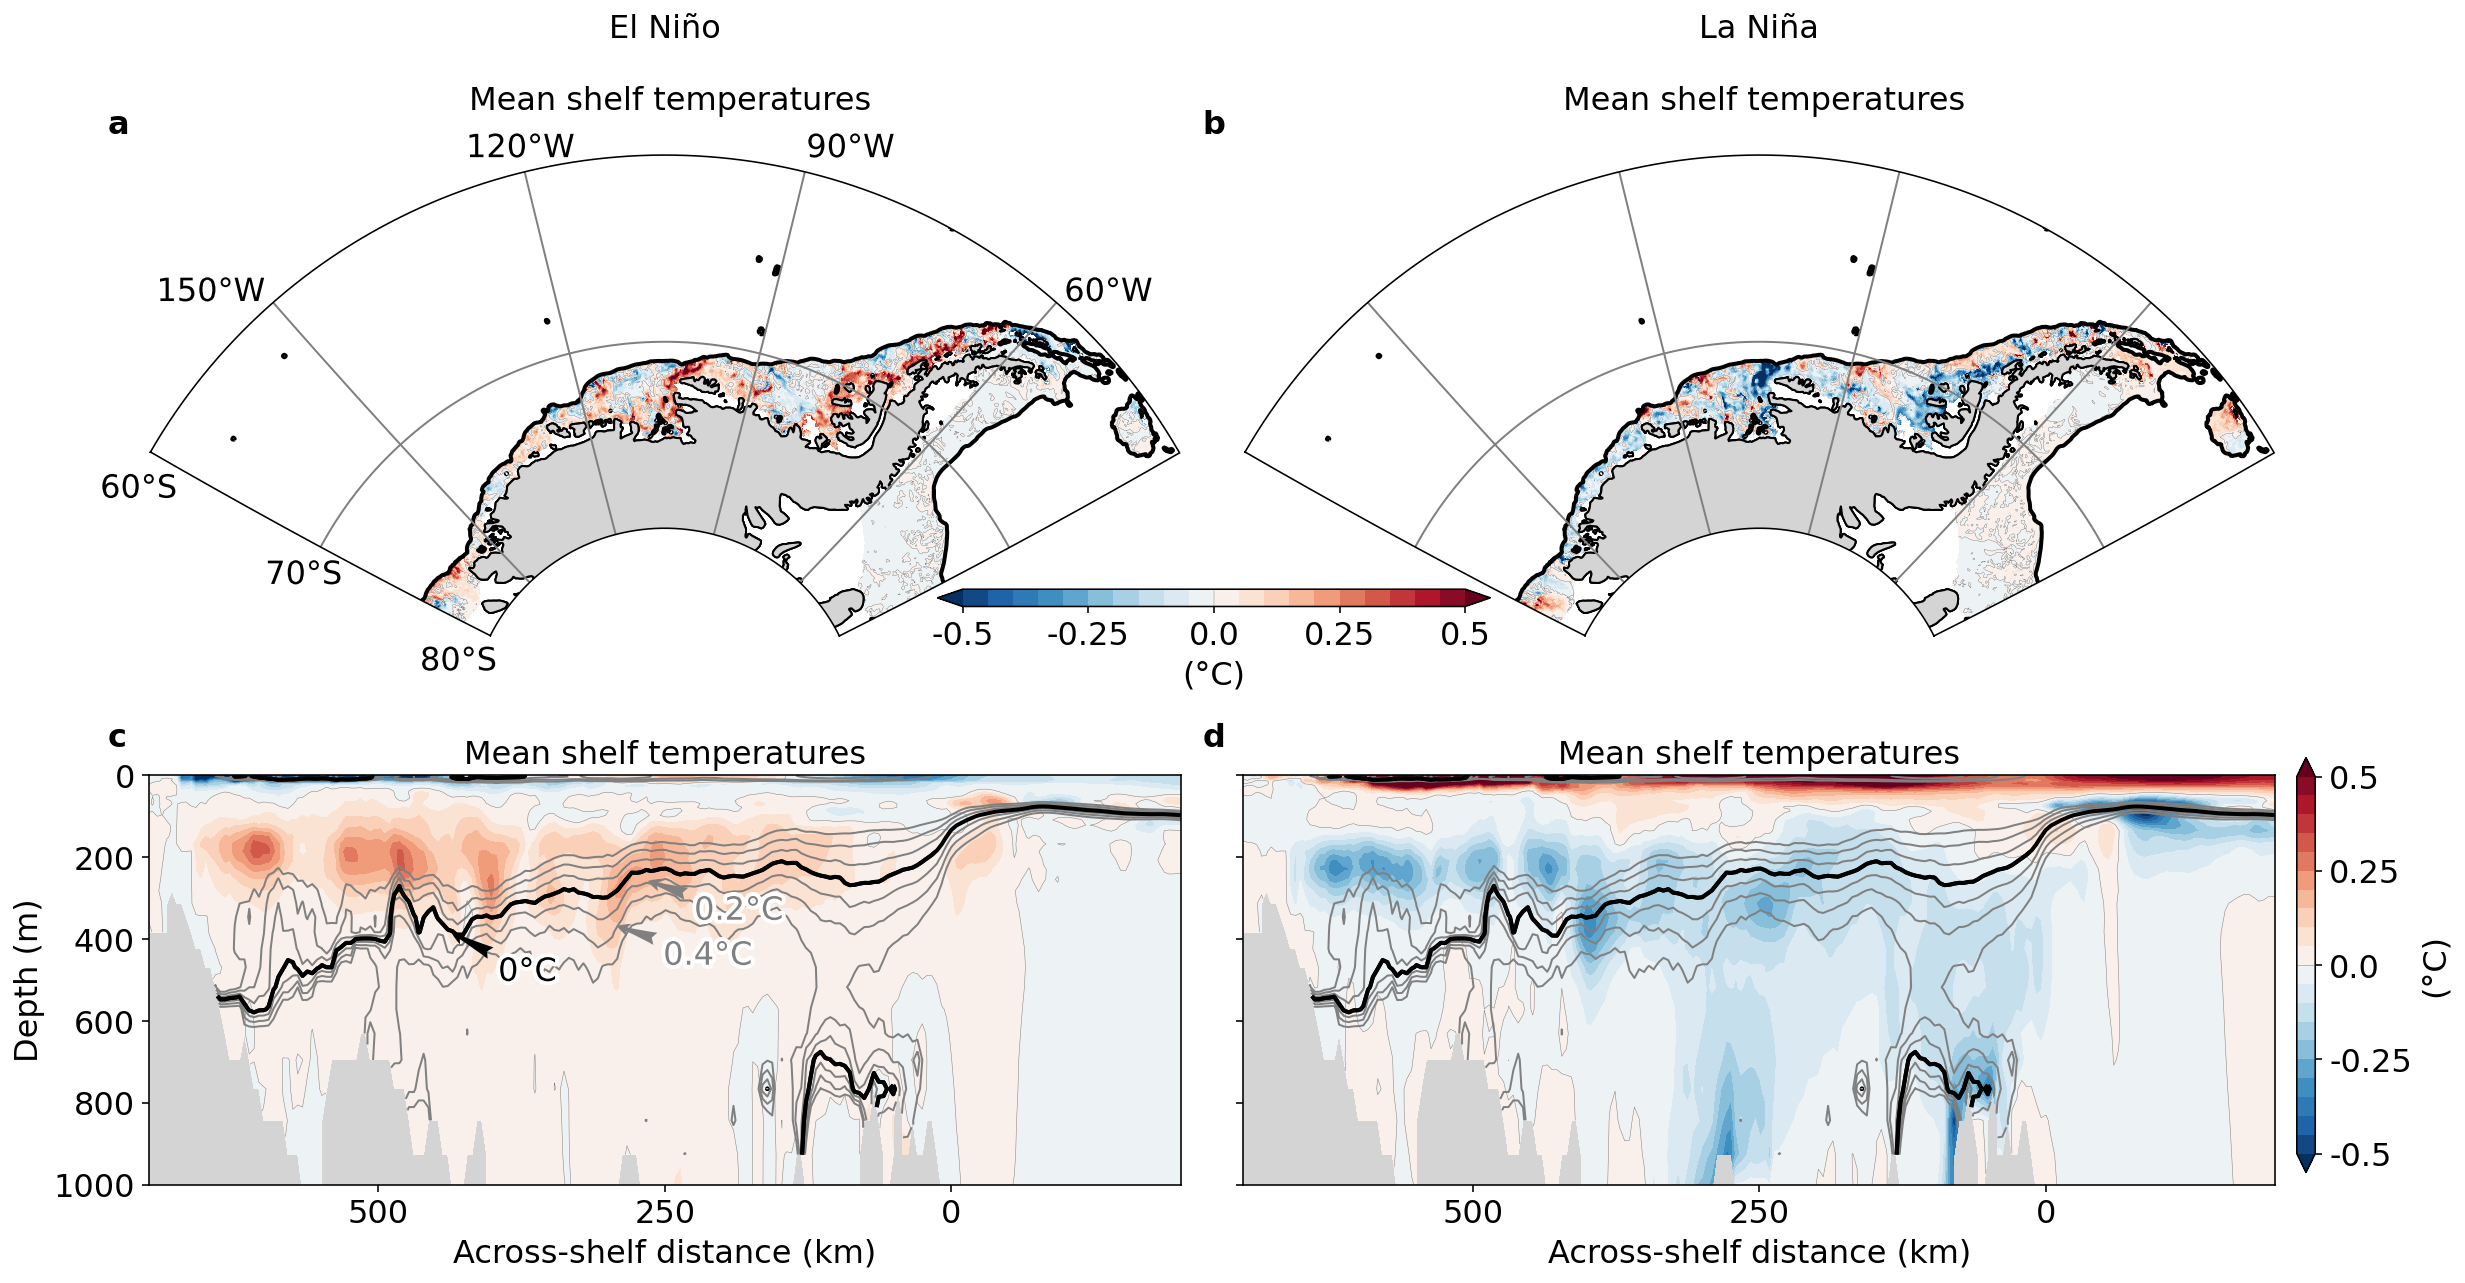

In [17]:
%%time
# Here the figure starts properly
fig = plt.figure(figsize=(16, 12),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(3,4, width_ratios = [1,1,1,1], height_ratios = [1,.75,.75]) 

midlon = -105
maxlon = midlon + 65
minlon = midlon - 65
minlat = -80
maxlat = -60
midlat = (minlat + maxlat)/2
ticks = np.linspace(-.5,.5,21)
ticks_depth_lat = np.linspace(-.5,.5,21)
month = 2 # only select timestep 3 of the dataset = 2045-12-16 12:00:00
for f in range(4): # loop through each subplot
    if f == 0:  panel = gs[0,0:2]; map = temp_EN_anom; titel = 'El Niño\n\n Mean shelf temperatures\n'; # zonal = anomEN_taux_large; meridional = anomEN_tauy_large
    if f == 1:  panel = gs[0,2:4]; map = temp_LN_anom; titel = 'La Niña\n\n Mean shelf temperatures\n'; # zonal = anomLN_taux_large; meridional = anomLN_tauy_large
                                                                                                                # isotherm positions during the event
    if f == 2:  panel = gs[1,0:2]; data = shelf_WA_EN; titel = 'Mean shelf temperatures'; iso = shelf_WA_clim
    if f == 3:  panel = gs[1,2:4]; data = shelf_WA_LN; titel = 'Mean shelf temperatures'; iso = shelf_WA_clim

#     if f == 4:  panel = gs[1,1]; data1 = u_EN.sum(['yu_ocean'])/1e6; data2 = v_EN.sum(['yu_ocean'])/1e6; titel = 'Ekman transport'
#     if f == 5:  panel = gs[1,3]; data1 = u_LN.sum(['yu_ocean'])/1e6; data2 = v_LN.sum(['yu_ocean'])/1e6; titel = 'Ekman transport'
        
    # if f == 6: panel = gs[2,0:2]; titel = 'Head budget terms'
    # if f == 7: panel = gs[2,2:4]; titel = 'Head budget terms'
    
#     if f == 6:
#         time = np.linspace(1,len(temp_submeso_EN), len(temp_submeso_EN))
        
#         temp_submeso = temp_submeso_EN; temp_tendency = temp_tendency_EN; temp_advection = temp_advection_EN; temp_vdiffuse_diff_cbt = temp_vdiffuse_diff_cbt_EN
#         temp_nonlocal_KPP = temp_nonlocal_KPP_EN; sw_heat = sw_heat_EN; temp_vdiffuse_sbc = temp_vdiffuse_sbc_EN; sfc_hflux_pme = sfc_hflux_pme_EN
#         frazil_3d = frazil_3d_EN; temp_eta_smooth = temp_eta_smooth_EN; temp_rivermix = temp_rivermix_EN
#     if f == 7:
#         time = np.linspace(1,len(temp_submeso_LN), len(temp_submeso_LN)) # for La Niña, the time series is longer
        
#         temp_submeso = temp_submeso_LN; temp_tendency = temp_tendency_LN; temp_advection = temp_advection_LN; temp_vdiffuse_diff_cbt = temp_vdiffuse_diff_cbt_LN
#         temp_nonlocal_KPP = temp_nonlocal_KPP_LN; sw_heat = sw_heat_LN; temp_vdiffuse_sbc = temp_vdiffuse_sbc_LN; sfc_hflux_pme = sfc_hflux_pme_LN
#         frazil_3d = frazil_3d_LN; temp_eta_smooth = temp_eta_smooth_LN; temp_rivermix = temp_rivermix_LN


    # panels with spatial maps -------------------------------------------------------------------------------------------------------------------- #
    if f in [0,1]:
        ax1 = plt.subplot(panel, projection=ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat))
        ax1.coastlines(resolution='50m')

        lons = geolon_t.sel(xt_ocean=slice(minlon, maxlon)).sel(yt_ocean=slice(minlat, maxlat))
        lats = geolat_t.sel(xt_ocean=slice(minlon, maxlon)).sel(yt_ocean=slice(minlat, maxlat))

        ax1.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())

        boundary_path = make_boundary_path(lons, lats)
        ax1.set_boundary(boundary_path, transform=ccrs.PlateCarree())

        # ----------------------------------------------------------------------------------------------------------------------------------------- #
        p1   = map.plot.pcolormesh(add_colorbar=False, levels=ticks, cmap='RdBu_r', transform=ccrs.PlateCarree())
        p11  = map.plot.contour(levels = [0], linewidths=.1, cmap='k', transform=ccrs.PlateCarree())
        # 1000 dbar isobath
        p111 = field.plot.contour(levels = [1000], linewidths=2, cmap='k', transform=ccrs.PlateCarree()) # 1000 m isobath
        # ----------------------------------------------------------------------------------------------------------------------------------------- #
                
        fancy_plot(ax1); # plt.suptitle('Shelf temperatures and surface wind stress', fontsize=16)
        plt.title(titel, fontsize=16)
        ax1.text(-.04, 1.05 ,string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top

        # add colour bar .675
        cax = fig.add_axes([.41, .645, .24, .01]) # position: [x0, y0, width, height]
        from matplotlib.ticker import FuncFormatter
        fmt = lambda x, pos: '{:.2}'.format(x)                              # format tick labels so that I have (-.5, -.25,0,.25,.5)
        cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='horizontal', format=FuncFormatter(fmt)); 
        cb_txt = cb.set_label(label='(°C)', size=16)
        cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
        cb.locator = tick_locator;cb.update_ticks()
        cb.add_lines(p11) # add contours to colour bar
    
        # lines showing across-shelf transects at 101°W and 75°W
        # ax1.plot([-101, -101], [-76, -70], color = rotblau[ 1], linewidth=3, transform=ccrs.PlateCarree(),)
        # ax1.plot([ -75,  -75], [-75, -67], color = rotblau[20], linewidth=3, transform=ccrs.PlateCarree(),)
        


        # adding the region rectangles for AS and BS
        # AS = [-127,-101,-77,-70]; BS = [-101,-80,-77,-70]; PR = [-80,-63, -74, -63]
        # adding text label
        # ax1.text(-121, -76, 'AS',ha='center',va='center',transform=ccrs.Geodetic(), fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        # ax1.text( -95, -76, 'BS',ha='center',va='center',transform=ccrs.Geodetic(), fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        # ax1.text( -66, -72, 'AP',ha='center',va='center',transform=ccrs.Geodetic(), fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 
        
#         # special grid lines showing the Amundsean and Bellingshausen Sea regions
#         # this looks really cool!
#         gl = ax1.gridlines(color='k', linewidth=2, xlocs=[AS[0], AS[1]], ylocs= [AS[2], AS[3]], xlim=[AS[0], AS[1]], ylim=[AS[2], AS[3]])
#         gl = ax1.gridlines(color='k', linewidth=2, xlocs=[BS[0], BS[1]], ylocs= [BS[2], BS[3]], xlim=[BS[0], BS[1]], ylim=[BS[2], BS[3]]) # latitude grid lines
        
        
        # gl = ax1.gridlines(color='k', linewidth=2.5, alpha=1 , xlocs=[PR[0], PR[1]], ylocs= [PR[2], PR[3]], xlim=[PR[0], PR[1]], ylim=[PR[2], PR[3]]) # latitude grid lines

    # panels with depth-latitude temperature anomalies -------------------------------------------------------------------------------------------- #
    if f in [2,3]:
        ax1 = plt.subplot(panel)
        
        # ----------------------------------------------------------------------------------------------------------------------------------------- #
        p1  = data.plot.contourf(ax=ax1, levels = ticks_depth_lat, cmp='RdBu_r',extend='both', yincrease=False, add_colorbar=False)
        p11 = data.plot.contour(levels = [0], linewidths=.25, cmap='grey', yincrease=False)
        p22 = iso.plot.contour(levels=[-.6,-.4,-.2,0,.2,.4,.6], linewidths=1, cmap='grey', yincrease=False)
        p22 = iso.plot.contour(levels=[0], linewidths=2, cmap='k', yincrease=False)
        p22 = iso.plot.contour(levels=[0], linewidths=2, cmap='k', yincrease=False)

        labels1 = plt.clabel(p22,  # Typically best results when labelling line contours.
                   colors=['grey'], fontsize=16, manual=False,  # Automatic placement vs manual placement.
                   inline=True,  # Cut the line where the label will be placed.
                   fmt=' {:.05f} '.format)  # Labes as integers, with some extra space.
        # ----------------------------------------------------------------------------------------------------------------------------------------- #
        
        if f == 2:
            plt.ylabel('Depth (m)', fontsize=16)
            ax1.text(-.04, 1.07 ,string.ascii_lowercase[2], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
            
            # adding arrow   # end_coords, start_coords
            arrow_text = ax1.annotate('0°C',
                                      xy=(.29, .62), xycoords='axes fraction', xytext=(50, -50), textcoords='offset pixels',
                                      fontsize=16,arrowprops=dict(facecolor='k', ec = 'none',arrowstyle="fancy"))
            arrow_text.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')]) 
        
            for l in range(2): # annotation arrows and labels
                if l == 0: coords = (.48, .745); txt = '0.2°C'
                if l == 1: coords = (.45, .635); txt = '0.4°C'
                arrow_text = ax1.annotate(txt, color='grey',
                    xy=coords, xycoords='axes fraction', xytext=(50, -40), textcoords='offset pixels',
                    fontsize=16,arrowprops=dict(facecolor='grey', ec = 'none',arrowstyle="fancy"))
                arrow_text.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')]) 
        if f == 3: 
            plt.ylabel(None)
            ax1.text(-.04, 1.07 ,string.ascii_lowercase[3], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        if f in [2,3]: 
            plt.xlim([-77,-68]); plt.locator_params(axis='x', nbins=4) # only 3 y-axis ticks
            # replace the xticklabels with kilometer values -> I can do that because latitude distance is constant
            labels = [item.get_text() for item in ax1.get_xticklabels()]; ax1.set_xticklabels(['', '500', '250', '0']) # replace labels in °N with across-shelf distance
            plt.xlabel('Across-shelf distance (km)', fontsize=16)
            
        # if f in [3,5]: 
        #     plt.xlim([-74,-69]);
        #     labels = [item.get_text() for item in ax1.get_xticklabels()]; ax1.set_xticklabels(['330', '220', '110', '0', '110']) # replace labels in °N with across-shelf distance
        fancy_plot2(ax1, titel)
        plt.ylim([1000, 0])
        

        # hide superfluous tick labels and ticks
        if f in [3,4,5]:
            ax1.set_yticklabels([])
        if f == 3:
            # add colour bar        
            cax = fig.add_axes([1, .3175, .008, .24]) # position: [x0, y0, width, height]
            from matplotlib.ticker import FuncFormatter
            fmt = lambda x, pos: '{:.2}'.format(x)                              # format tick labels so that I have (-.5, -.25,0,.25,.5)
            cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='vertical', format=FuncFormatter(fmt)); 
            cb_txt = cb.set_label(label='(°C)', size=16)
            cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
            cb.locator = tick_locator;cb.update_ticks()
            cb.add_lines(p11) # add contours to colour bar

            

            # panels with zonal and meridional wind stresses ---------------------------------------------------------------------------------------------- #
    if f in [4]:
        ax1 = plt.subplot(panel)
        window = 15 # rolling mean for a nicer layout with less squiggles
        # -------- #
        data2.rolling(xu_ocean=window, center=True).mean() .plot(label='Northward', c=rotblau[ 3], linewidth=2) # northward
        data1.rolling(xu_ocean=window, center=True).mean() .plot(label= 'Eastward', c=rotblau[17], linewidth=2) # eastward, .rolling(xu_ocean=window, center=True).mean() 
        # -------- #
        
        fancy_plot3(ax1); plt.legend(fontsize=16, ncol=1) # panel legend
        ax1.text(-.08, 1.05 ,string.ascii_lowercase[3], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        plt.locator_params(nbins=4)
    if f in [5]:
        ax1 = plt.subplot(panel)
        
        # -------- #
        data2.rolling(xu_ocean=window, center=True).mean() .plot(c=rotblau[ 3], linewidth=2)
        data1.rolling(xu_ocean=window, center=True).mean() .plot(c=rotblau[17], linewidth=2) # use a 5 grid cell rolling mean
        # -------- #
        
        fancy_plot3(ax1); ax1.set_yticklabels([]); ax1.set_ylabel(None)
        ax1.text(-.04, 1.05 ,string.ascii_lowercase[5], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
        plt.locator_params(nbins=4)

# two additional panels with the heat budget terms
        
#     if f in [6,7]: 
#         ax1 = plt.subplot(panel)
        
#         plt.plot(time, temp_tendency/1e6,                                                      label = 'Heat content tendency', linewidth = 3, color = 'k')
#         plt.plot(time, temp_advection/1e6,                                                     label = 'Heat transport conv.', linewidth = 2, color = rotblau[3])
#         plt.plot(time, (temp_vdiffuse_diff_cbt+temp_nonlocal_KPP)/1e6,                         label = 'Surface forcing',       linewidth = 2, color = rotblau[7])
#         plt.plot(time, (temp_submeso+temp_vdiffuse_sbc+sw_heat+temp_eta_smooth+frazil_3d)/1e6, label = 'Vertical mixing',       linewidth = 2, color = rotblau[14])
#         plt.plot(time, temp_rivermix/1e6,                                                      label = 'Surface volume',        linewidth = 2, color = rotblau[19])
#         numerical = temp_tendency - (temp_submeso+temp_advection+temp_vdiffuse_diff_cbt+temp_nonlocal_KPP+sw_heat+temp_vdiffuse_sbc+
#                          +frazil_3d+temp_eta_smooth+temp_rivermix)
#         plt.plot(time, numerical/1e6, label = 'Numerical mixing', linewidth = 2, linestyle='--')
#         fancy_plot4(ax1)
#         plt.ylim([-.85,.35])
#         ax1.text(-.04, 1.05 ,string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
#         plt.xlabel('Month', fontsize=16)

#     if f == 6:
#         plt.xlim([1,24])
#         ax1.set_ylabel('(10$^{6}$ W m$^{-2}$)', color='k', fontsize=16) # hide x-axis label
#         handles, labels = ax1.get_legend_handles_labels() # get the handles to plot only one legend for the two panels
#         plt.legend(fontsize=16, ncol=2, loc='lower center')
#     if f == 7:
#         plt.xlim([12,36])
#         ax1.set_yticklabels([]); ax1.set(ylabel=None) 

# fig.legend(handles, labels, fontsize=16, ncol=3, bbox_to_anchor=(.5, -.3), loc='lower center') # figure legend at the bottom of the plot
    
# --- saving as 300 dpi .PNG image in specified folder ----------------------------------- #
plt.savefig(save + 'temp_anomalies_sector_cake_ACCESS-OM2-01-new', dpi=300, facecolor='w',     #
            edgecolor='w', orientation='landscape', papertype=None,                        #
            format=None, transparent=False, bbox_inches='tight',                           #
            pad_inches=0.1, metadata=None)                                                 #
# --- end of script ---------------------------------------------------------------------- # 
# Wall time: 37 s

Caption notes:
- showing a single month, i.e., month 12/24 of the simulation
- (a, b): 100 - 1000 m mean temperature on the shelf masked with the 1000 m isobath
- (c, d): West Antarctic temperature anomalies in the upper 1000 m
- (g, h): rolling mean of 15 grid cells for Ekman velocities

You can see a wider selection of cartopy projections here: https://scitools.org.uk/cartopy/docs/latest/crs/projections.html